# Timeseries Forecasting Practice (Statsmodels only)

In [808]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
import plotly.graph_objects as go
import plotly.express as px 
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('talk')

In [809]:
train = pd.read_csv('/Users/jack/Desktop/rossman_sales/train.csv',index_col=['Date'],parse_dates=['Date'])

test = pd.read_csv('/Users/jack/Desktop/rossman_sales/test.csv',index_col=['Date'],parse_dates=['Date'])

<Axes: xlabel='Date', ylabel='Sales'>

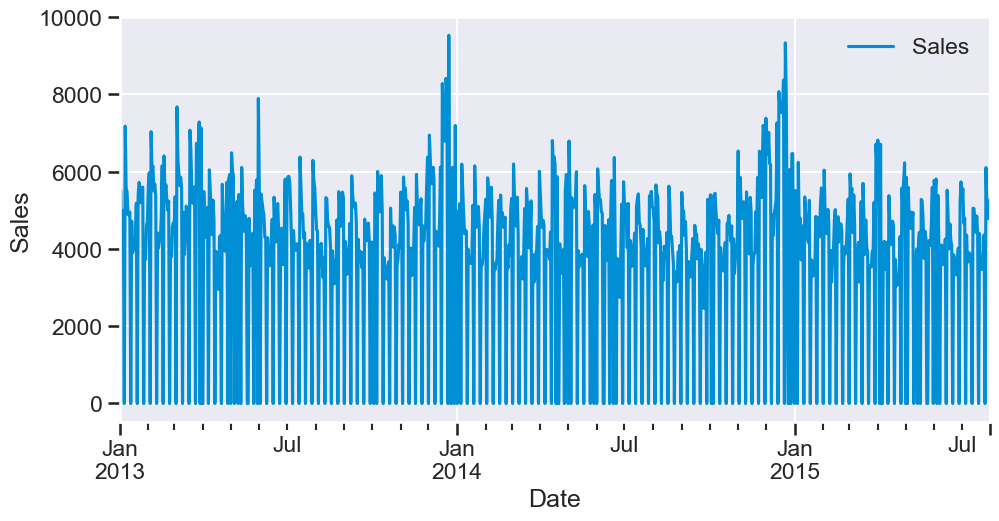

In [810]:
#for now we will forecast store 1's sales 

ts_1 = train[train.Store == 1]

ts_1.plot(y='Sales',figsize=(10,5),
          xlabel='Date',
          ylabel='Sales')

<Axes: title={'center': 'Store 1 Sales 2014'}, xlabel='Date', ylabel='Sales'>

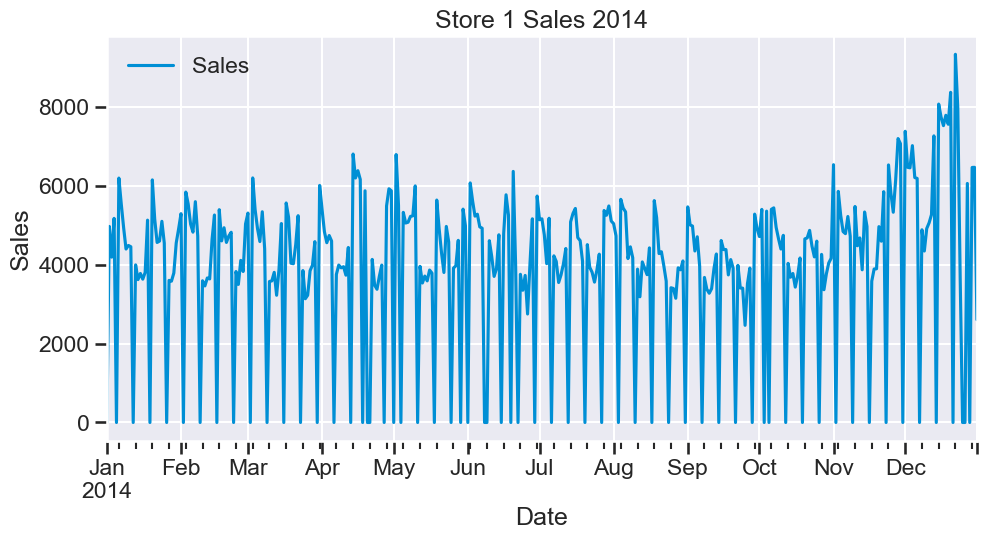

In [811]:
# lets zoom in a bit and get a closer look. 
ts_1.loc['2014'].plot(y='Sales',figsize=(10,5),
          xlabel='Date',
          ylabel='Sales',
          title='Store 1 Sales 2014')

it looks like we have weekly, yearly seasonality that is already apparent. We also have a store closure. This is probably on weekends. 

In [812]:
# lets plot seasonal patterns, as usual we will use boxplots 

from feature_engine.datetime import DatetimeFeatures

dtf = DatetimeFeatures(variables=['Date'],
                       features_to_extract=['day_of_week','day_of_month',
                                            'month','quarter','week','weekend']).fit_transform(ts_1.reset_index())

first, lets examine how these features effect demand. 

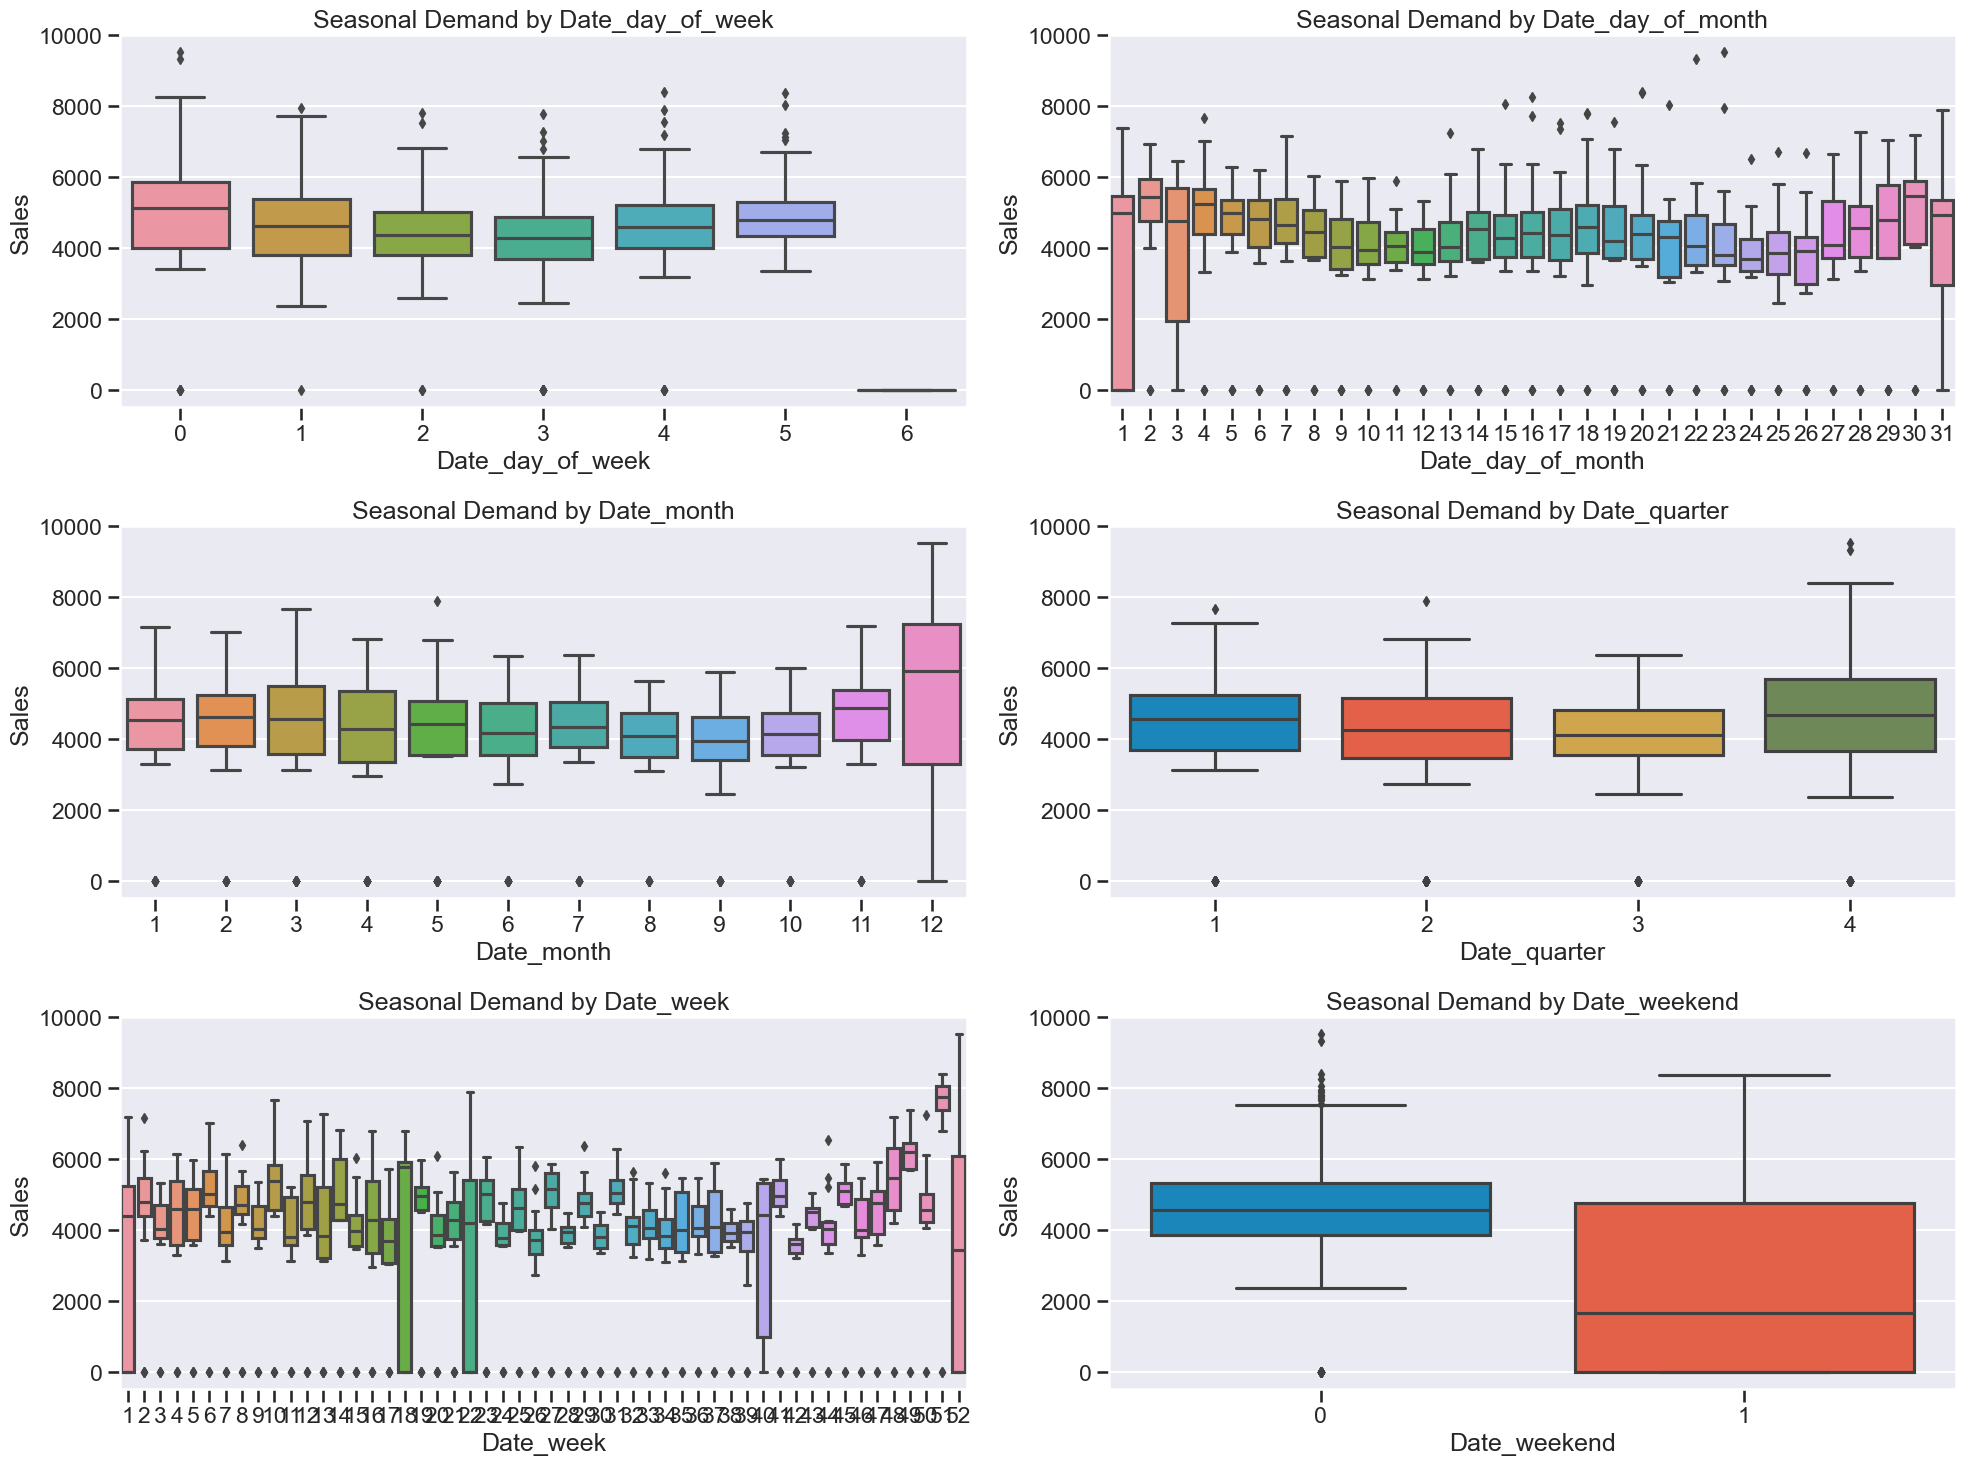

In [813]:
seasonal_feats = [x for x in dtf.columns if 'Date' in x]

fig, axs = plt.subplots(figsize=(20,15),nrows = (len(seasonal_feats) + 1) // 2,
                        ncols=2)

ax = axs.flatten()

for i,sp in enumerate(seasonal_feats): 
    
    sns.boxplot(dtf,x=sp,y='Sales',ax=ax[i])
    
    ax[i].set_title(f'Seasonal Demand by {sp}')
    
fig.tight_layout()

clear monthly, weekly and yearly patterns here. It looks like the store is closed on sundays, this is important. 

In [814]:
ts_1.groupby('StateHoliday').Sales.sum() # i am not sure what is going on with this column, maybe we use it to inform closures on days that aren't weekends? 

StateHoliday
0     486814
0    3230040
a          0
b          0
c          0
Name: Sales, dtype: int64

In [815]:
ts_1.query('StateHoliday in("a","b","c")') # interesting, it looks like this is a holiday flag. We will use it to inform store closures. 

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-06-04,1,4,0,0,0,1,a,0
2015-05-25,1,1,0,0,0,0,a,0
2015-05-14,1,4,0,0,0,0,a,0
2015-05-01,1,5,0,0,0,1,a,0
2015-04-06,1,1,0,0,0,0,b,1
2015-04-03,1,5,0,0,0,1,b,1
2015-01-01,1,4,0,0,0,0,a,1
2014-12-26,1,5,0,0,0,0,c,1
2014-12-25,1,4,0,0,0,0,c,1


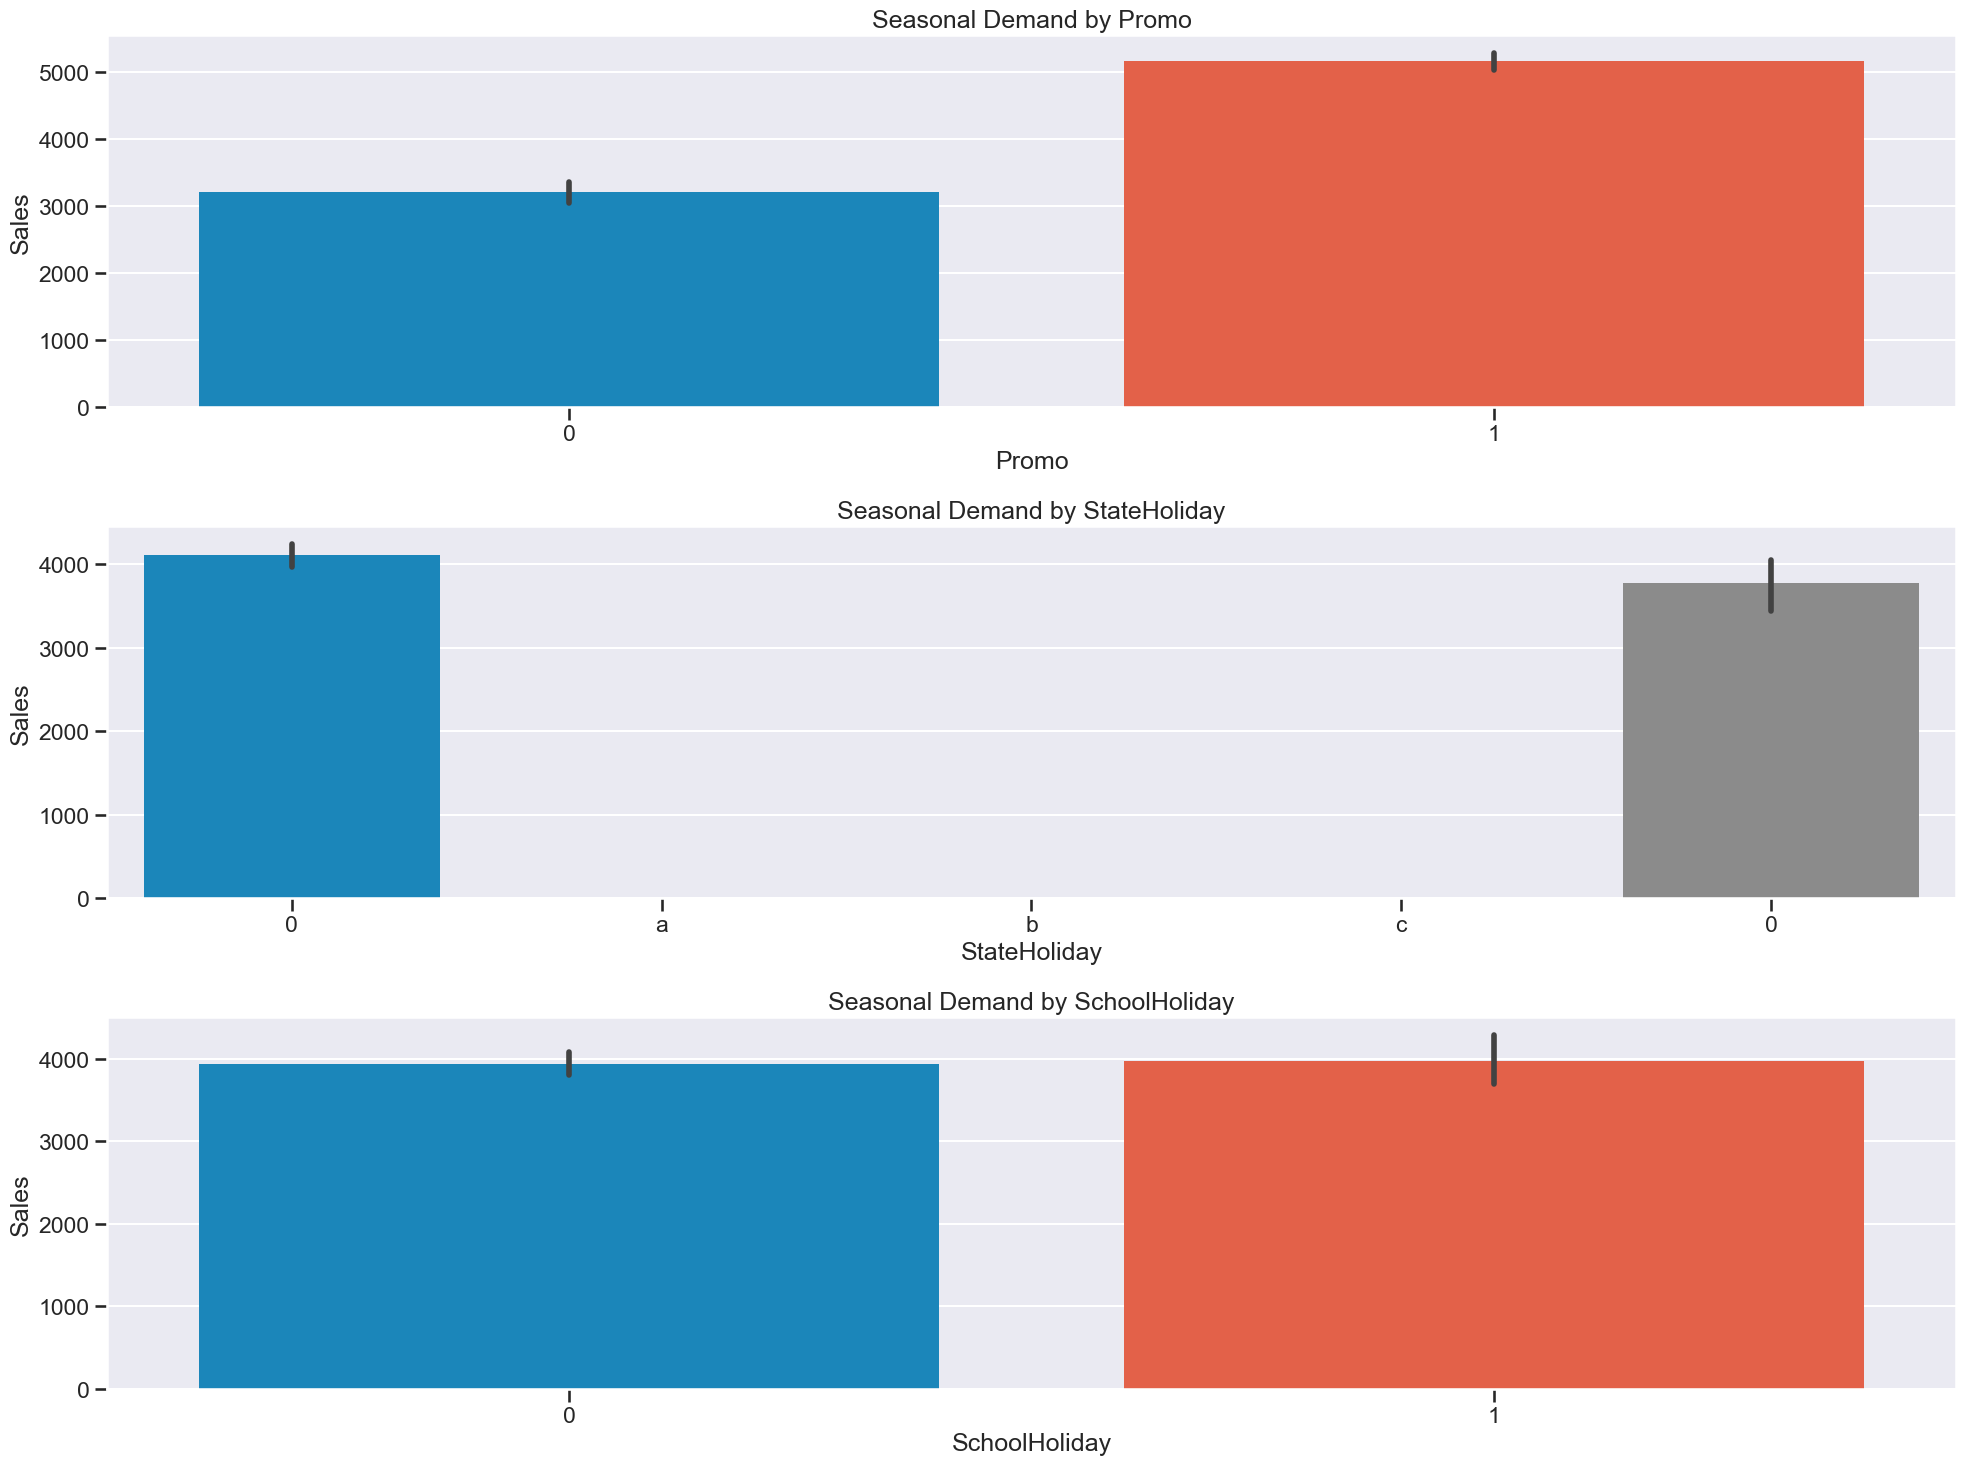

In [816]:
# lets look at holidays now 
seasonal_feats = [x for x in dtf.columns if 'Holiday' in x or 'Promo' in x]

fig, axs = plt.subplots(figsize=(20,15),nrows = 3)

ax = axs.flatten()

for i,sp in enumerate(seasonal_feats): 
    
    sns.barplot(dtf,x=sp,y='Sales',ax=ax[i])
    
    ax[i].set_title(f'Seasonal Demand by {sp}')
    
fig.tight_layout()

school holidays have no effect at this store but it looks like Promos have a healthy lift on sales.


 lets look at the relationship in store traffic and sales (customer foot traffic)

In [817]:
ts_1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [818]:
fig = px.scatter(ts_1,x='Sales',y='Customers',
           title='Relationship Between Foot Traffic (Customers) and Sales',
           trendline='ols')

fig.update_layout(xaxis_title='Sales (Units)',
                  yaxis_title='Foot Traffic (# Customers)',
                  width=1000,
                  height=600) 

as we suspected, a very strong linear trend is present. We will use customers as a predictor alongside others in a SARIMAX model..

In [819]:
ts_1.corr(numeric_only=True)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DayOfWeek,NaN,1.000000,-0.502143,-0.495904,-0.544070,-0.392929,-0.067935
Sales,NaN,-0.502143,1.000000,0.984341,0.889360,0.471333,0.007692
Customers,NaN,-0.495904,0.984341,1.000000,0.927965,0.377675,-0.000020
Open,NaN,-0.544070,0.889360,0.927965,1.000000,0.299053,-0.000096
Promo,NaN,-0.392929,0.471333,0.377675,0.299053,1.000000,0.028374
SchoolHoliday,NaN,-0.067935,0.007692,-0.000020,-0.000096,0.028374,1.000000


In [820]:
#lets look at school holidays, they didn't have an impact on sales and maybe we can ditch that features 
ts_1.groupby('SchoolHoliday')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
SchoolHoliday,,,,,,,,
0,749.0,3937.839786,1993.627747,0.0,3601.0,4396.0,5220.0,8414.0
1,193.0,3976.227979,2102.906842,0.0,3482.0,4280.0,5252.0,9528.0


In [821]:
ts_1.query('Promo == 0').groupby('SchoolHoliday')['Sales'].agg(['mean','median']) # without a promotional period, school holidays don't add much to the model 

,mean,median
SchoolHoliday,,
0,3191.641026,3851.5
1,3229.184211,3764.5


In [822]:
ts_1[['Open']].value_counts(normalize=True) # looks like the store was open a large portion of the time as well.
#This feature may or may not be more useful as a "closed" feature. 


Open
1       0.829087
0       0.170913
Name: proportion, dtype: float64

array([[<Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'Customers'}>]], dtype=object)

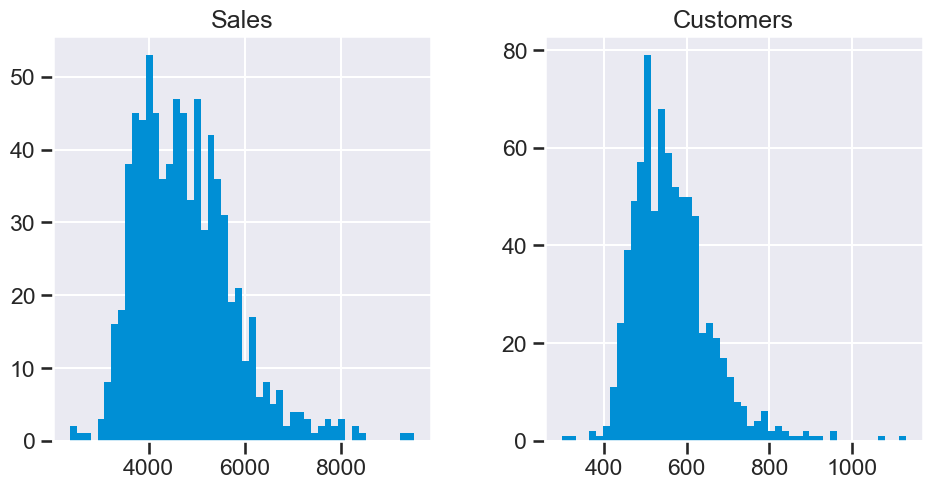

In [823]:
ts_1.query('Open == 1').hist(column=['Sales','Customers'],
                             bins=50,
                             figsize=(10,5))

#it looks like sales and customer are near identical, which is interesting, they are also both log normal. lets transform them and reevaluate

In [824]:
sales = ts_1.query('Open == 1')[['Sales']]

array([[<Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'log_sales'}>]], dtype=object)

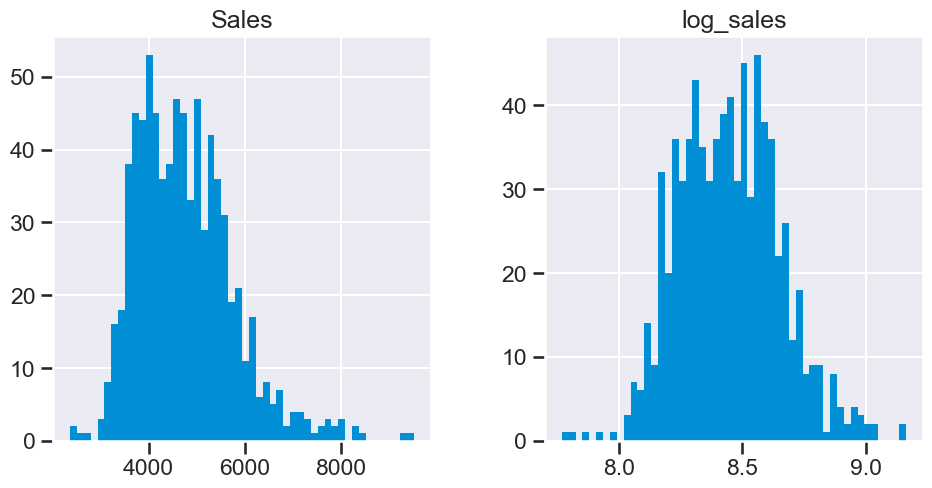

In [825]:
plt.rc('figure',figsize=(10,5
                         ))

tmp = sales.assign(log_sales = np.log(sales['Sales']))

tmp.hist(bins=50) # ok great, now we can log transform the target variable to ensure we get better predictions. 

In [826]:
#make log of sales out target variable, we must do this before looking at autocorrelative components 
target = tmp['log_sales']

<Axes: title={'center': 'Log Of Sales'}, xlabel='Date'>

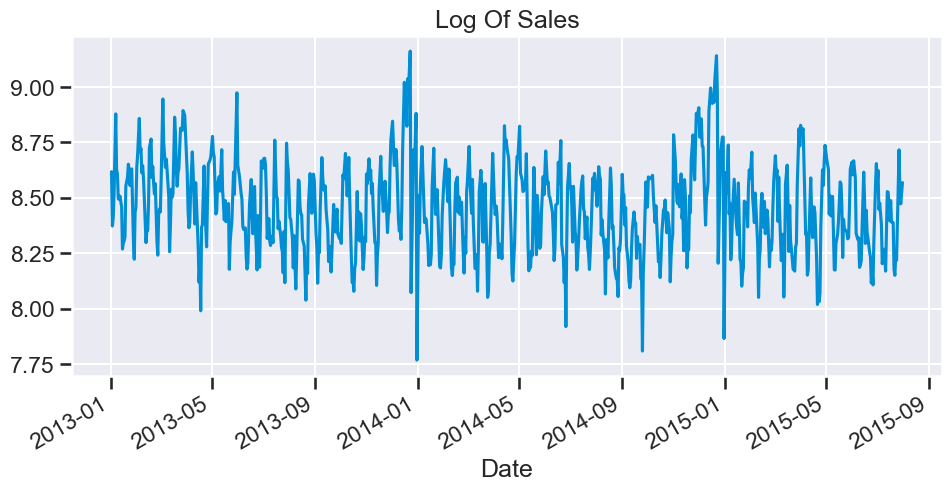

In [827]:
# sort index 

target = target.sort_index()

target.plot(title='Log Of Sales')

In [828]:
from statsmodels.tsa.seasonal import MSTL 
#lets decompose our series to get a better look 
res = MSTL(target, 
     periods=(7, # weekly
              7*4, # monthly 
              365, # yearly 
            #  7*4*3, # quarterly
              #7*4*6 # bi-annually? 
              ),
     #stl_kwargs = {'seasonal_deg':0}
     ).fit()

Plot Decomposition

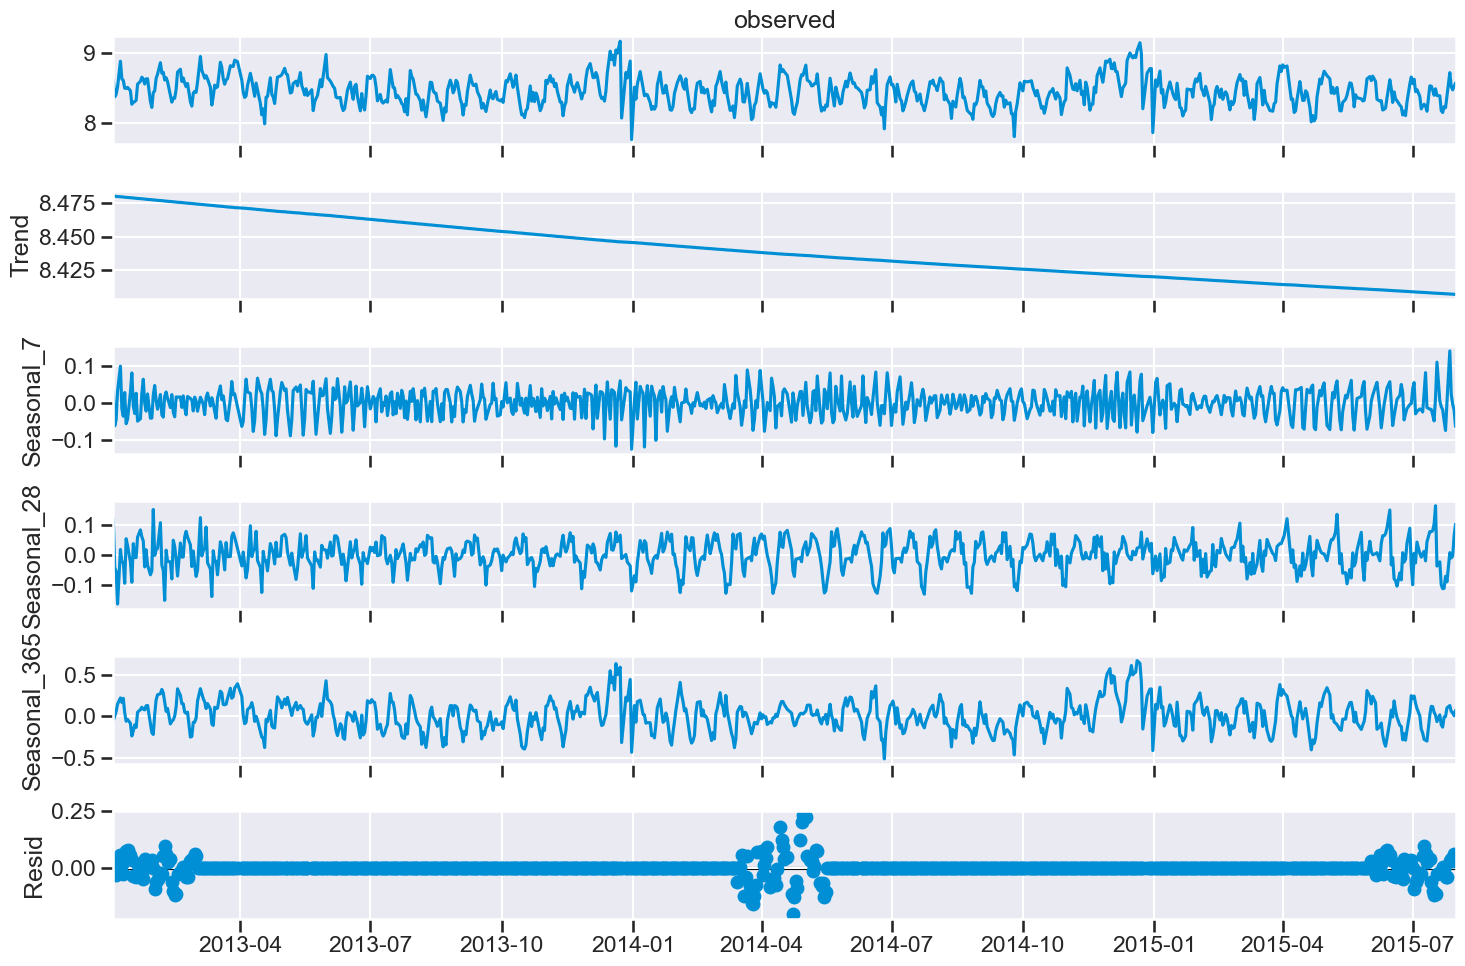

In [829]:
plt.rc('figure',figsize=(15,10
                         ))

res.plot();

<Axes: xlabel='Date'>

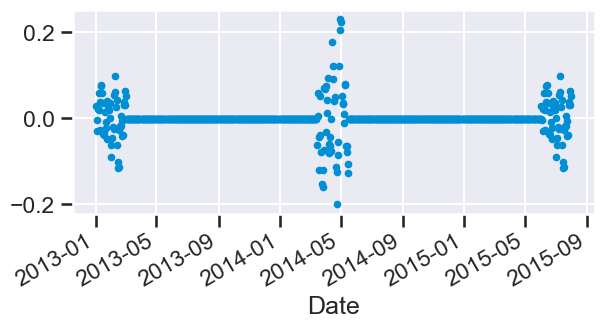

In [830]:
#lets examine the residuals 

res.resid.plot(linestyle=' ',marker='.',figsize=(6,3)) 

the residuals have a seasonal component in them, this looks like it could be from holiday effect? 

In [831]:

# lets look into that january to july period and see if any signal is there
mask = (ts_1.index.month >= 1) & (ts_1.index.month <= 7)

tmp_a = ts_1.loc[mask][['Sales','Customers','Open','Promo','SchoolHoliday']].describe().T[['mean','std']]

tmp_b = ts_1.loc[~mask][['Sales','Customers','Open','Promo','SchoolHoliday']].describe().T[['mean','std']]

In [832]:
tmp_a.join(tmp_b,rsuffix='_Normal') # all i can see here is the higher proportion of schoo holidays? #could this be tax return season in a retail environment ? 

,mean,std,mean_Normal,std_Normal
Sales,3896.360063,1963.918684,4048.264706,2118.079106
Customers,463.050314,224.846539,477.199346,237.285087
Open,0.825472,0.379862,0.836601,0.370335
Promo,0.388365,0.487762,0.369281,0.483401
SchoolHoliday,0.154088,0.361317,0.310458,0.463439


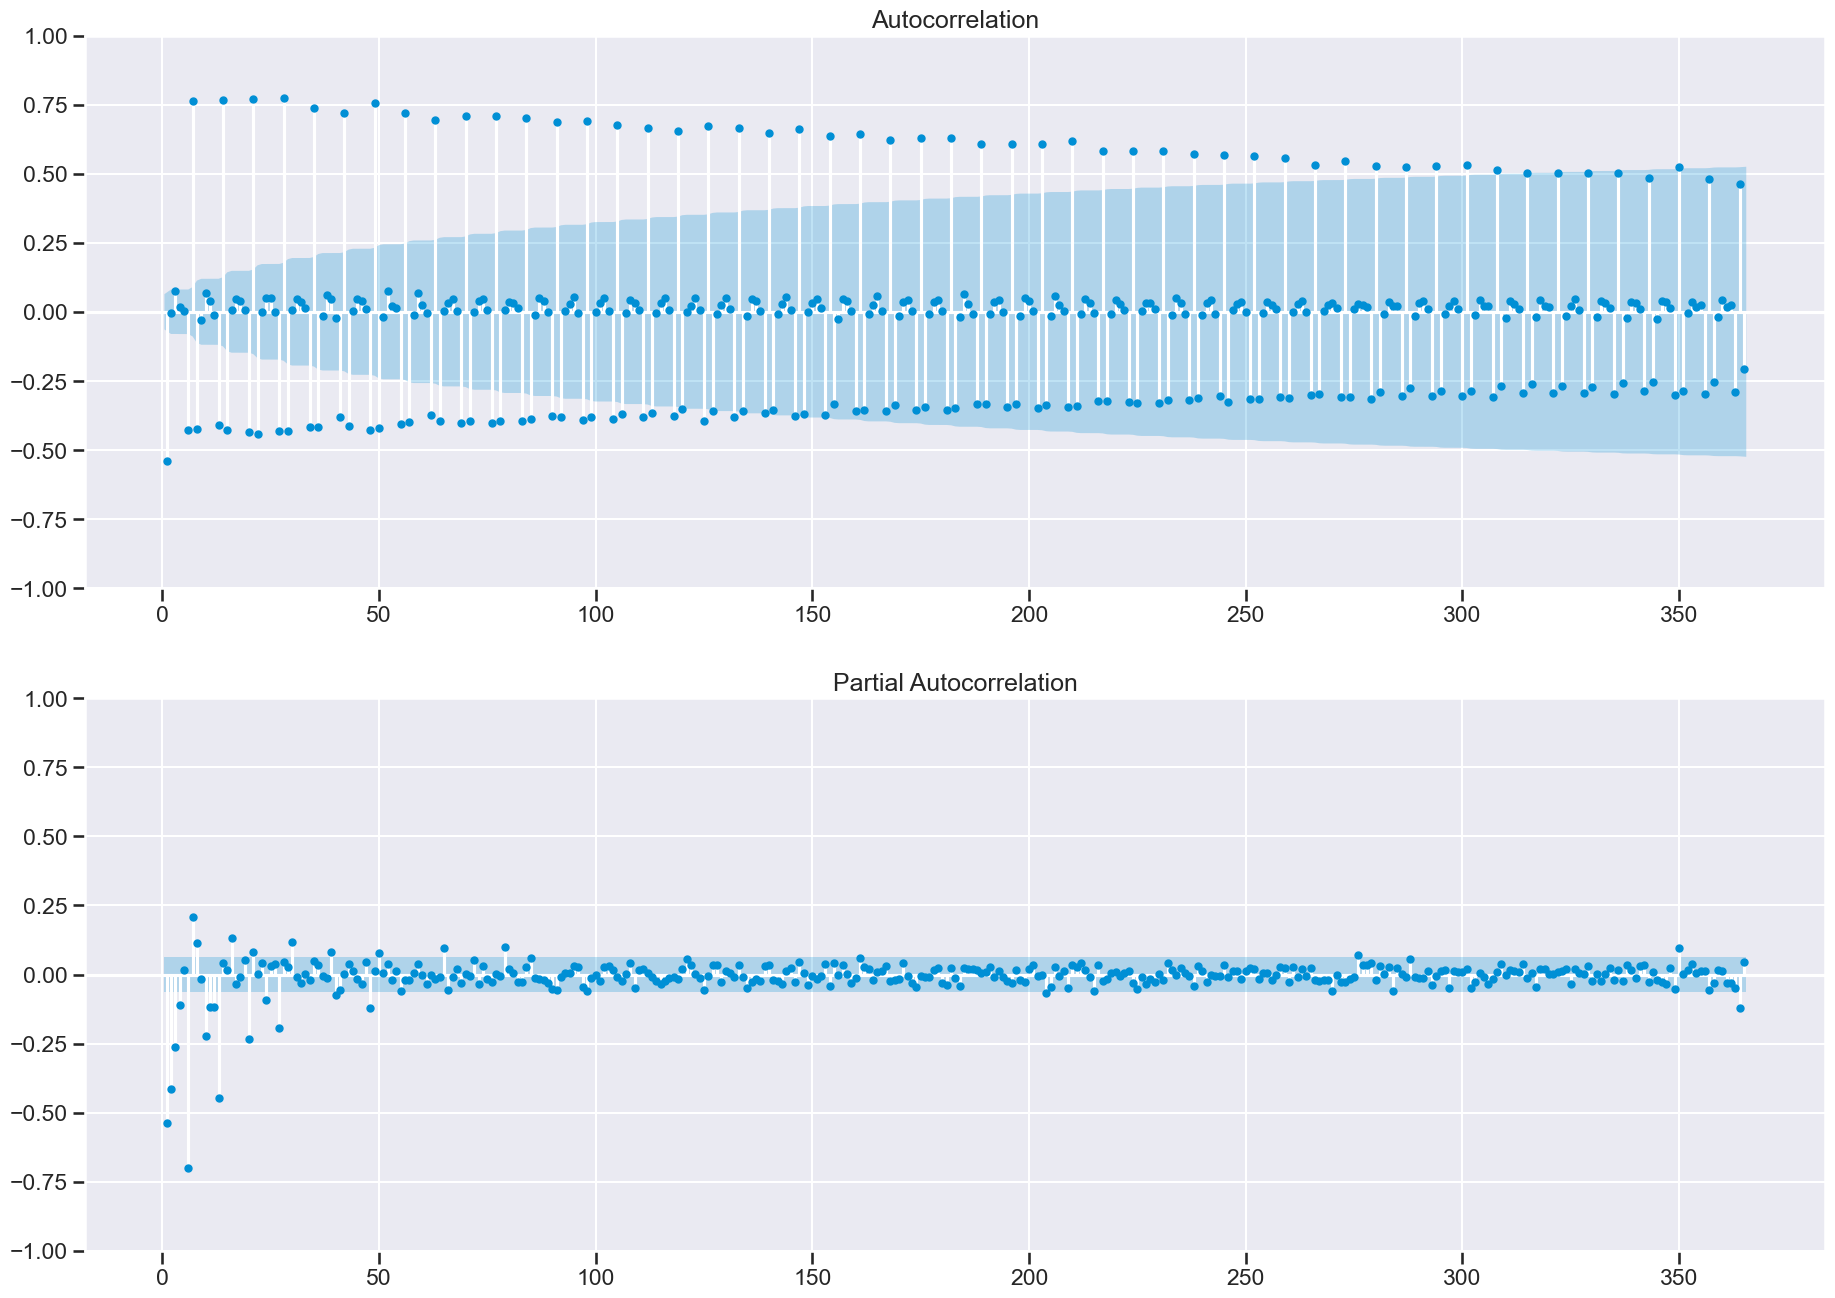

In [833]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs = plt.subplots(nrows=2,
                        figsize=(20,15))

plot_acf(ts_1['Sales'].diff().dropna(),zero=False,ax=axs[0],lags=365)

plot_pacf(ts_1['Sales'].diff().dropna(),zero=False,ax=axs[1],lags=365)

fig.show()

we can see after detrending the series, that lags all the way up to a year could be predictive 

lets zoom in to see those closer lags. 

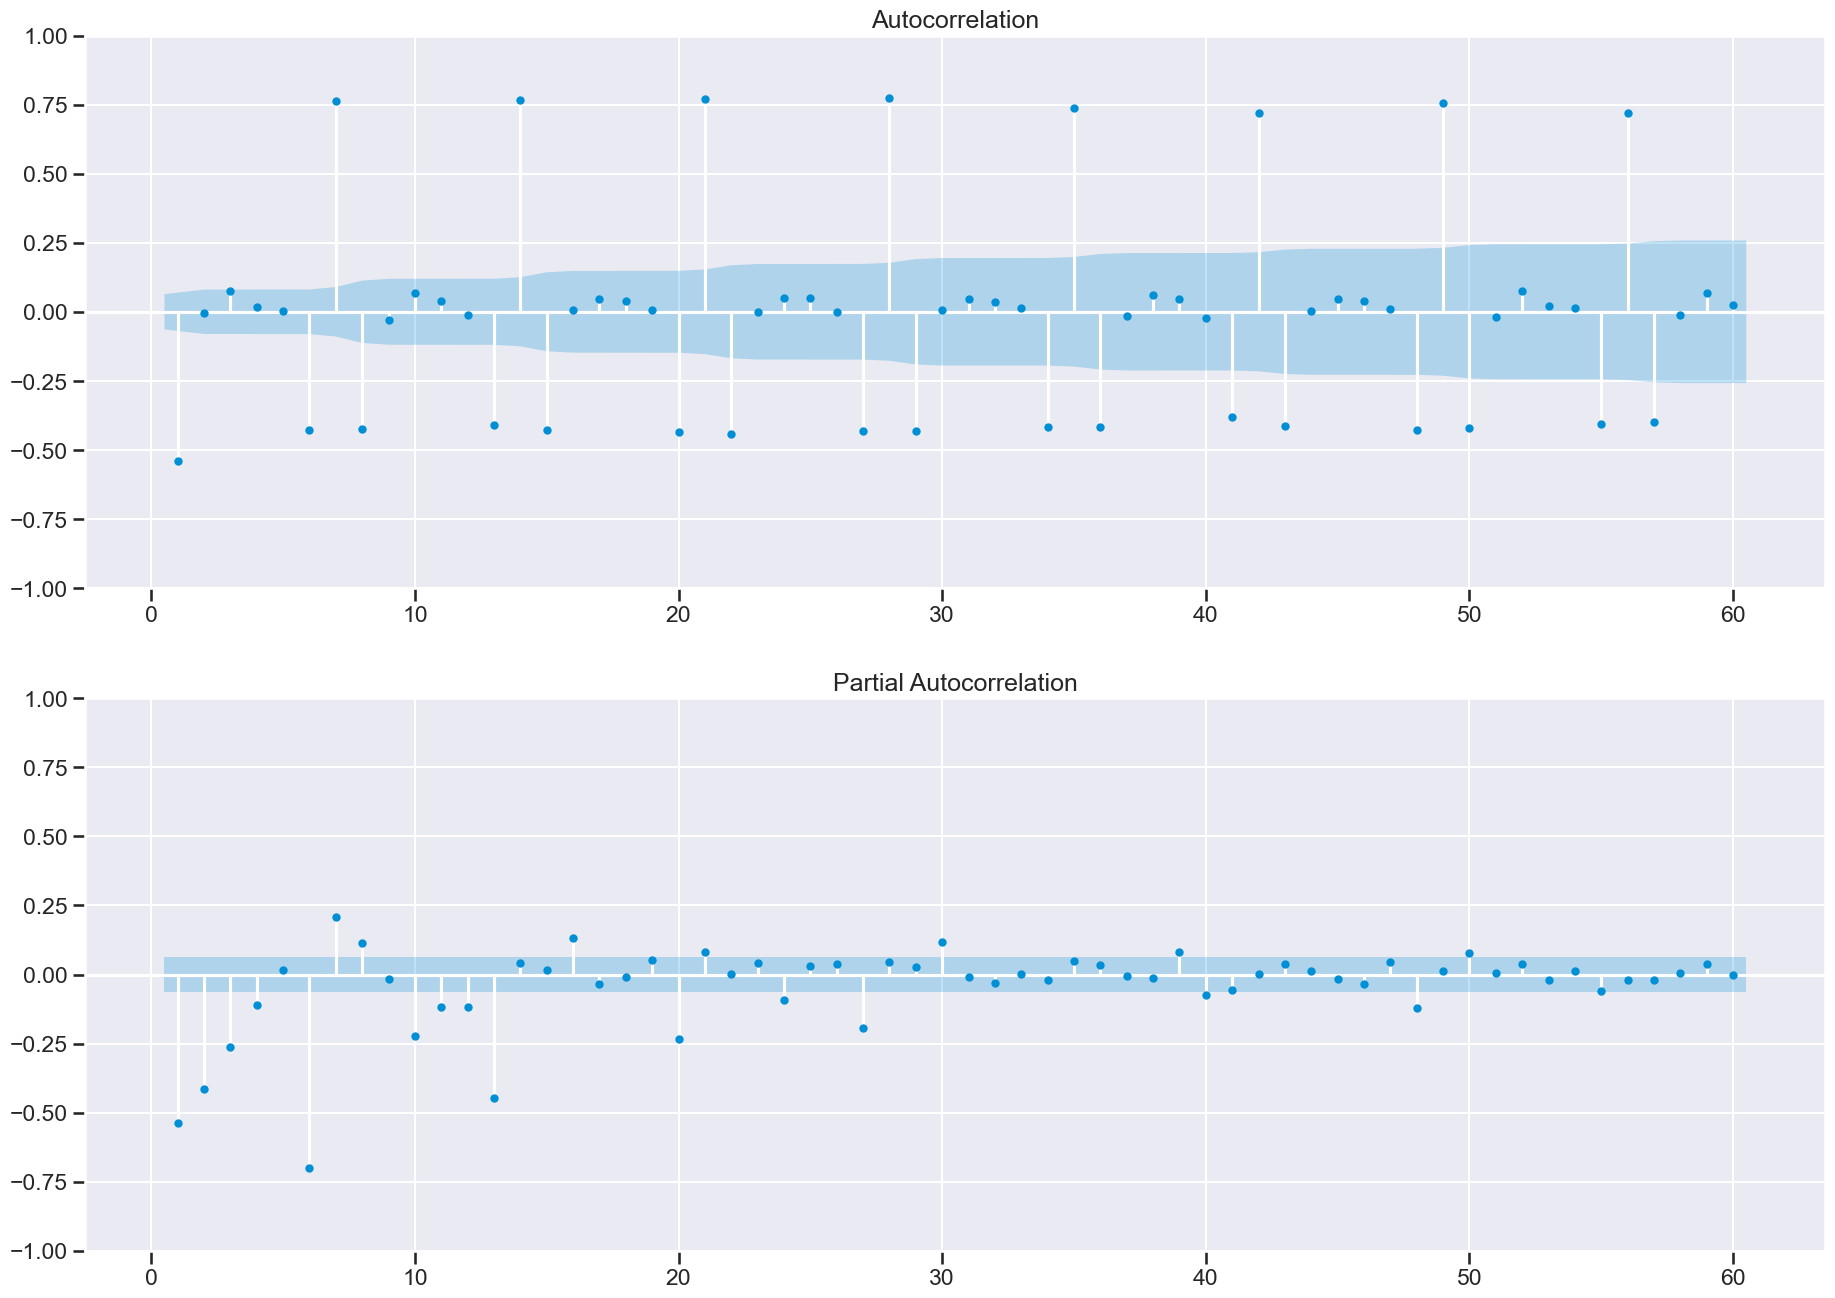

In [834]:
fig, axs = plt.subplots(nrows=2,
                        figsize=(20,15))

plot_acf(ts_1['Sales'].diff().dropna(),zero=False,ax=axs[0],lags=60)

plot_pacf(ts_1['Sales'].diff().dropna(),zero=False,ax=axs[1],lags=60)

fig.show()

now lets plot pacf and acf of our time series at a single seasonal difference

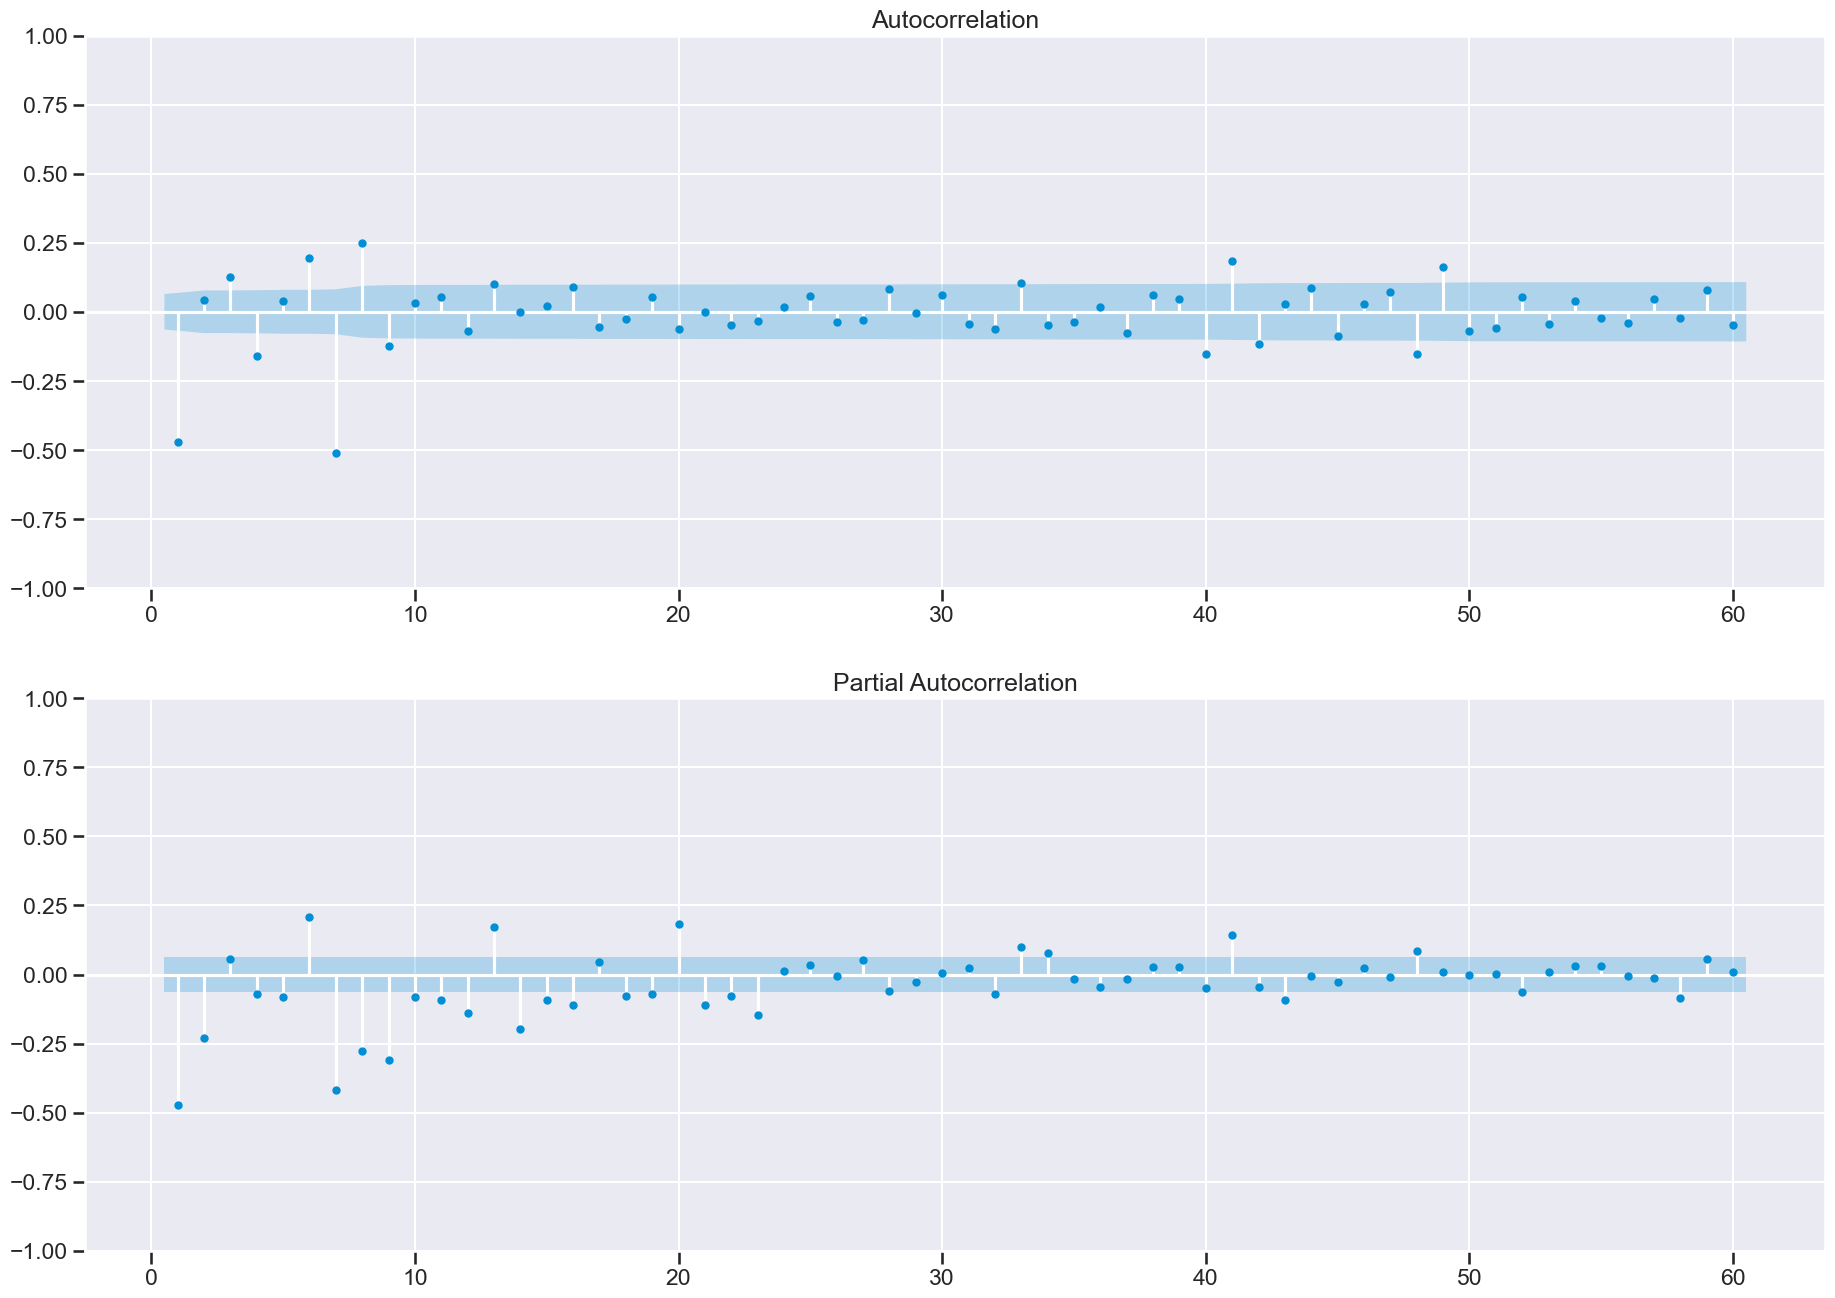

In [835]:
fig, axs = plt.subplots(nrows=2,
                        figsize=(20,15))

plot_acf(ts_1['Sales'].diff().diff(7).dropna(),zero=False,ax=axs[0],lags=60)

plot_pacf(ts_1['Sales'].diff().diff(7).dropna(),zero=False,ax=axs[1],lags=60)

fig.show()

cool, just as we suspected we see clear weekly, and monthly seasonality. It also looks like a strong effect at lag 14 as well. Interesting. 

notes: it we can deduce that we have strong seasonality, a moderate trend alongside a huge jump during the holidays.

* lets ensure the series is stationary and examine visually

* then begin modeling. As mentioned I will try a SARIMAX. 

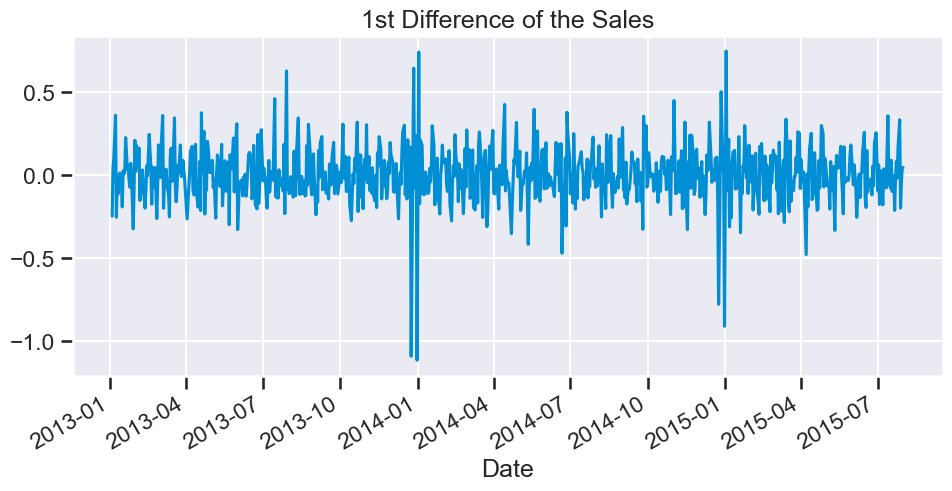

In [836]:
target.diff().dropna().plot(figsize=(10,5),
                                   title='1st Difference of the Sales')
plt.show()

test it using adfuller

In [837]:
from statsmodels.tsa.stattools import adfuller, kpss

diff = target.dropna()

#adfuller test for stationarity 
result = adfuller(diff)

if result[1] < .05: 
    print(f'The Augmented Dicky Fuller Test is reading stationary.')
    
else: 
    print(f'The Series is not stationary. We must difference it.')
    
kpss_res = kpss(diff)

kpss_res

The Augmented Dicky Fuller Test is reading stationary.


(0.37522793414697847,
 0.08783278700561273,
 13,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [838]:
# now we must seasonally difference the data to test for stationarity 
import warnings
data_seasonal_diff = target.diff(7).dropna()
warnings.filterwarnings("ignore")
adfuller_result = adfuller(data_seasonal_diff)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(data_seasonal_diff)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -7.940872563877564, p-value: 3.316660358016451e-12
KPSS Statistic: 0.011936615314120214, p-value: 0.1


as can be seen we had to take the 1st difference of the series in order to ensure both the seasonally differenced and ARMA components are stationary.  

In [839]:
#imports 
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from feature_engine.transformation import LogCpTransformer

In [840]:
train_end = '2014-12-31' # train on data up to 2015 

#set freq/resample 
ts_1 = ts_1.asfreq('d')

train = ts_1.loc[:train_end]

#slice validation set 
valid_end = '2015-04-30' # end validation on data up to april 30 

valid = ts_1.loc[train.index.max() + pd.DateOffset(days=1):valid_end]

#test on remaining data 
test = ts_1.loc[valid.index.max() + pd.DateOffset(days=1):]

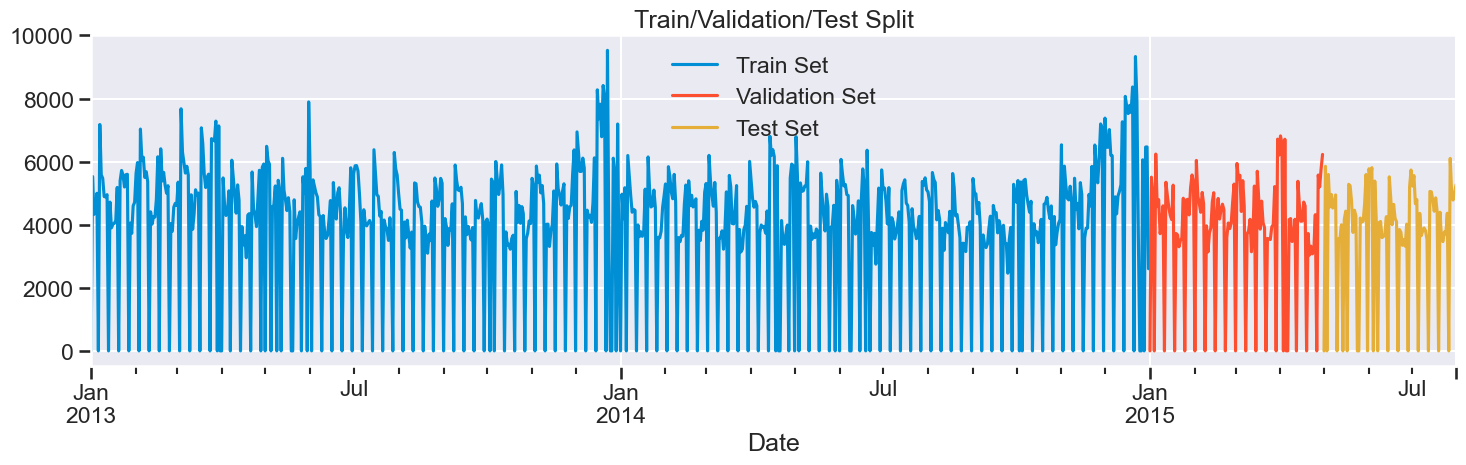

In [841]:
ax = train['Sales'].plot(figsize=(15,5),label='Train Set')

valid['Sales'].plot(label='Validation Set',
          ax=ax)

test['Sales'].plot(label='Test Set',
          ax=ax)

ax.legend()

ax.set_title('Train/Validation/Test Split')
plt.tight_layout()

we construct our model as (1,1,4) for our ARIMA p,d,q 

Our seasonal component consists of (1,1,1,7) P,D,Q,M

In [842]:
from sktime.transformations.series.boxcox import LogTransformer

forecaster = ForecasterSarimax( # ARIMA follows (p,d,q)
                 regressor=Sarimax(order=(1, # autocorrelative component
                                   1, # differencing (this is usually 1-2)
                                          4), # MA component (see PACF and you notice 4 significant lags)
                                   seasonal_order=(1, # autocorrelative component
                                                   1, # differencing (this is usually 1-2)
                                                   2, # MA component (see PACF and you notice 4 significant lags)
                                                   7), # seasonal periodicity 
                                   maxiter = 500,
                                   enforce_stationarity=False),
                 transformer_y = LogTransformer(offset=1)) # log transform target and add 1 as a constant for zeros 

In [843]:
forecaster.fit(y=train['Sales'])

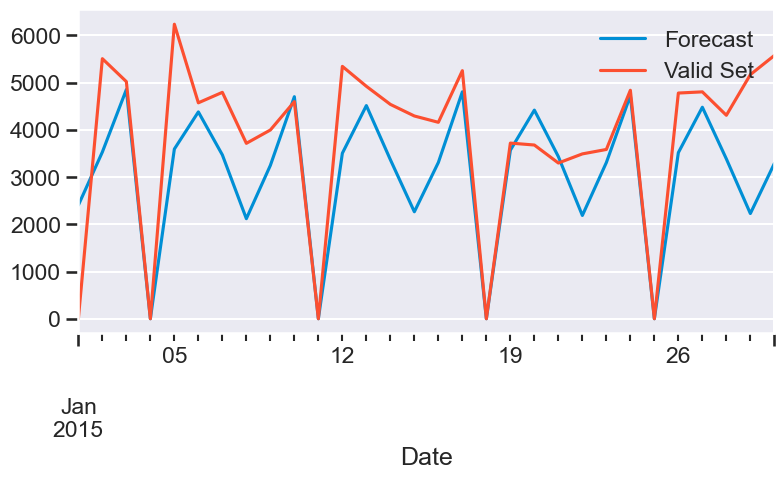

In [844]:
ax = forecaster.predict(steps=30).plot(label='Forecast',figsize=(8,4))
valid['Sales'].head(30).plot(label='Valid Set',ax=ax)
plt.legend()

the fit doesn't appear to bad, lets inspect the model summary. 

In [845]:
forecaster.regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Sales   No. Observations:                  730
Model:             SARIMAX(1, 1, 4)x(1, 1, [1, 2], 7)   Log Likelihood               -1230.218
Date:                                Sun, 02 Jun 2024   AIC                           2478.435
Time:                                        17:05:18   BIC                           2519.433
Sample:                                    01-01-2013   HQIC                          2494.280
                                         - 12-31-2014                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9510      0.047    -20.391      0.000      -1.042      -0.860
ma.L1          0.0242      2.130      0.011      0.991      -4.150       4.198
ma.L2         -0.9899      2.146     -0.461      0.645      -5.196       3.216
ma.L3         -0.0500      0.070     -0.720      0.472      -0.186       0.086
ma.L4          0.0158      0.106      0.149      0.882      -0.192       0.223
ar.S.L7       -0.3871      1.573     -0.246      0.806      -3.470       2.696
ma.S.L7       -0.6223      2.259     -0.276      0.783      -5.050       3.805
ma.S.L14      -0.3773      1.641     -0.230      0.818      -3.594       2.839
sigma2         1.8407      4.166      0.442      0.659      -6.324      10.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             26012.81
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -5.25
Prob(H) (two-sided):                  0.80   Kurtosis:                        30.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

What are we looking at here? 
* Log Likelihood 
    * a measure of how well the model explains the data. Often this will be negative and the more negative the worse the fit. 
* AIC/BIC: both goodness of fit metrics that penalize overly complex models. 

* Ljung-Box Test: looks at auto correlation in the residuals 
* Jarque Bera Test: looks at the normality of residuals 
* Skewness and Kurtosis look at distributional characteristics of the residuals. 

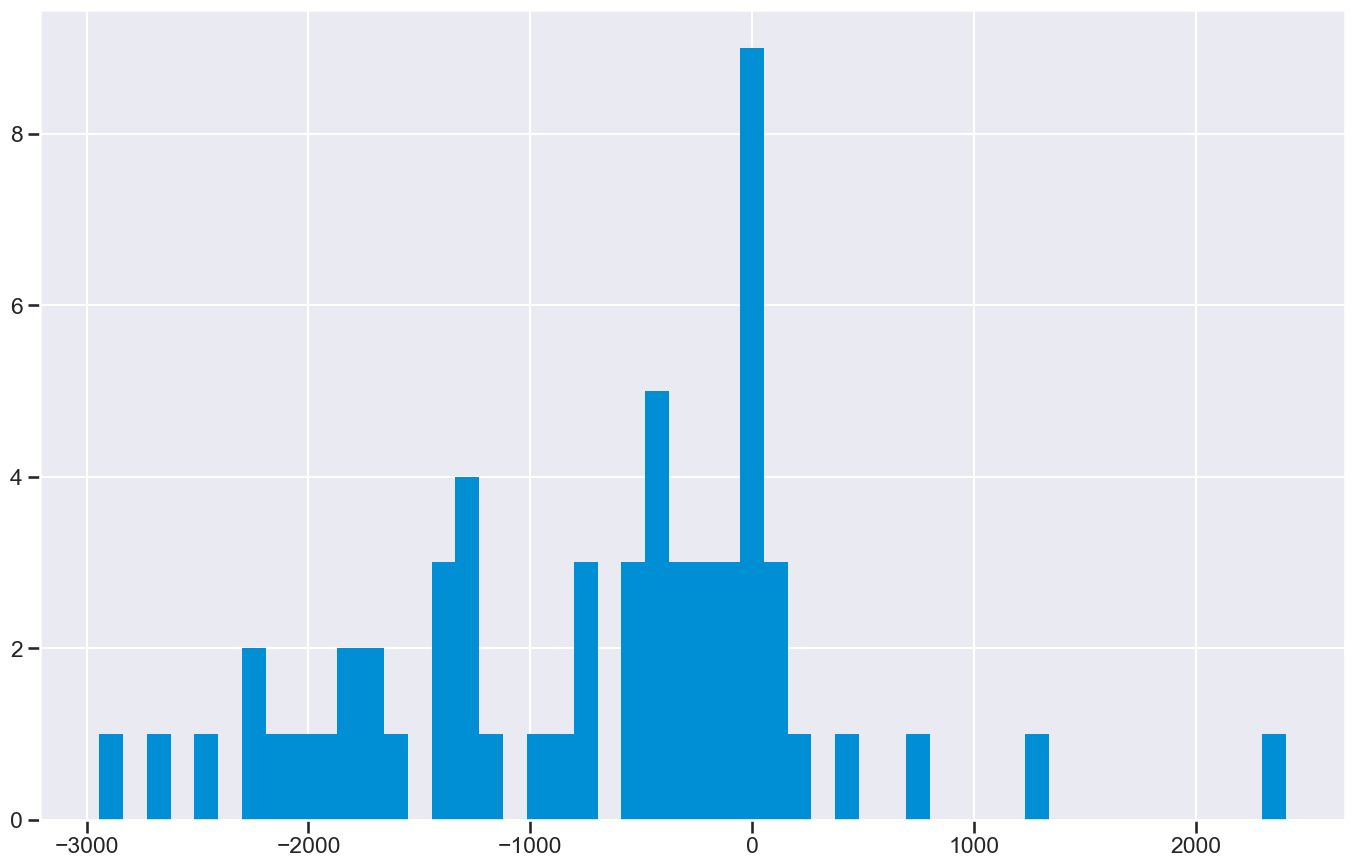

In [846]:
#lets plot the residuals without our exogenous features yet added 

pred = forecaster.predict(steps=60)

resid = pred.values - valid['Sales'].head(60)

from skforecast.plot import plot_residuals 

plt.hist(resid,bins=50)

plt.show() # ok, no autocorrelation and they look normal which is great!

# Adding Exogenous Variables, then we can re-evaluate our fit. 

In [847]:
exog_1 = ts_1.assign(holiday_closure = 
            np.where(ts_1['StateHoliday'] != '0',1,0))\
    .drop(columns=['StateHoliday','SchoolHoliday','Store','Sales','DayOfWeek','holiday_closure','Customers'])

<Axes: xlabel='Date'>

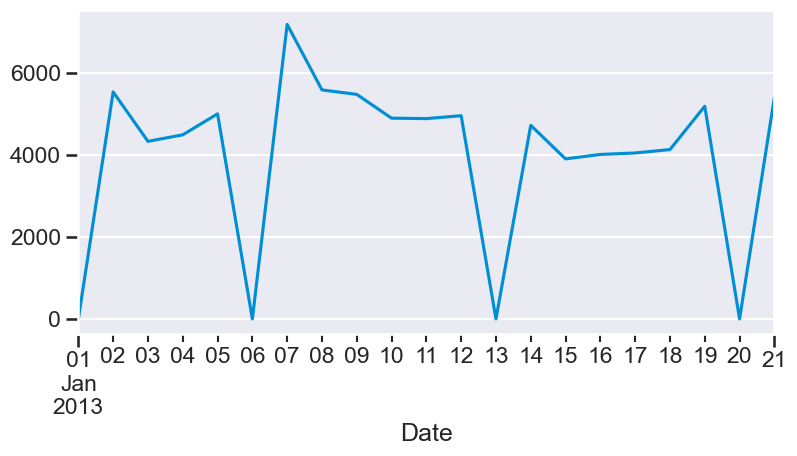

In [848]:
#now lets visualize this "day of week" seasonality, we will likely transform it to fourier series 

train['Sales'].head(21).plot(figsize=(8,4)) # this doesn't resemble a sine/cosine, so we'll create dummies instead

In [849]:
from feature_engine.encoding import OneHotEncoder 
#from sklearn.preprocessing import MinMaxScaler
#lets create future exog to ensure we can predict into the future with our new forecaster
from sklearn.pipeline import make_pipeline 
from sklearn import set_config 

set_config(transform_output='pandas')

exog_trns = make_pipeline(
    DatetimeFeatures(variables=['Date'],
features_to_extract=['day_of_week']),
OneHotEncoder(variables=['Date_day_of_week'],
ignore_format=True,
drop_last=True),
MinMaxScaler())# drop sundays, we are never open on sundays so this likely isn't important

In [850]:
#exog_1 = exog_1.assign(Date = exog_1.index.date)

In [851]:
#exog_1 = exog_trns.fit_transform(exog_1)

In [852]:
forecaster = ForecasterSarimax( # ARIMA follows (p,d,q)
                 regressor=Sarimax(order=(1, # autocorrelative component
                                          1, # differencing (this is usually 1-2)
                                          4), # MA component (see PACF and you notice 4 significant lags)
                                   seasonal_order=(1, # autocorrelative component
                                                   1, # differencing (this is usually 1-2)
                                                   2, # MA component (see PACF and you notice 4 significant lags)
                                                   7), # seasonal periodicity 
 maxiter=200),
                # transformer_exog=exog_trns,
                # # specify exog_transformer we will transform exog outside of our forecaster 
                 transformer_y = LogTransformer(offset=1),
                )

In [853]:
forecaster.fit(y=train['Sales'],
               exog = exog_1.loc[train.index])

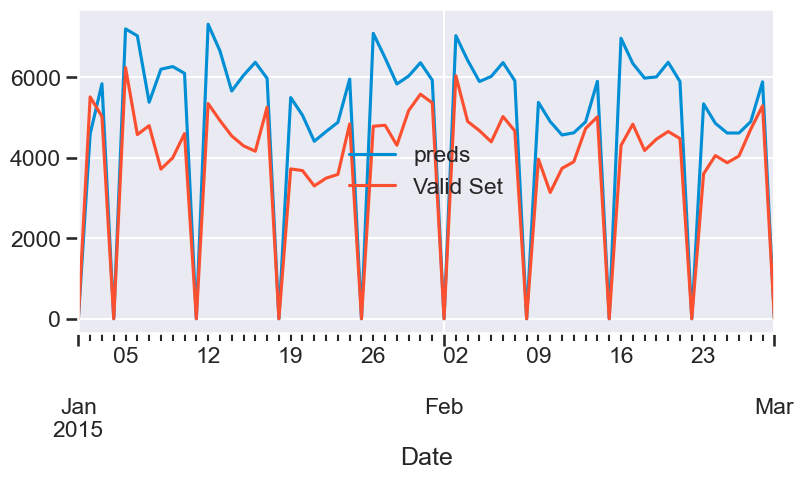

In [854]:
exog_valid = exog_1.loc[valid.index.min():]

ax = forecaster.predict(steps=60,
                   exog=exog_valid).plot(label='preds',figsize=(8,4))
valid['Sales'].head(60).plot(label='Valid Set',ax=ax)

plt.legend()

In [855]:
forecaster.regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Sales   No. Observations:                  730
Model:             SARIMAX(1, 1, 4)x(1, 1, [1, 2], 7)   Log Likelihood                 482.261
Date:                                Sun, 02 Jun 2024   AIC                           -942.522
Time:                                        17:06:09   BIC                           -892.120
Sample:                                    01-01-2013   HQIC                          -923.066
                                         - 12-31-2014                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Open           8.4879      0.023    369.367      0.000       8.443       8.533
Promo          0.2634      0.012     22.021      0.000       0.240       0.287
ar.L1         -0.8144      0.071    -11.393      0.000      -0.954      -0.674
ma.L1          0.1044      0.074      1.401      0.161      -0.042       0.250
ma.L2         -0.6100      0.063     -9.706      0.000      -0.733      -0.487
ma.L3         -0.0583      0.038     -1.546      0.122      -0.132       0.016
ma.L4         -0.1686      0.035     -4.812      0.000      -0.237      -0.100
ar.S.L7        0.7352      0.139      5.301      0.000       0.463       1.007
ma.S.L7       -1.5870      0.303     -5.234      0.000      -2.181      -0.993
ma.S.L14       0.5877      0.221      2.655      0.008       0.154       1.022
sigma2         0.0148      0.003      4.408      0.000       0.008       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               461.67
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -0.51
Prob(H) (two-sided):                  0.04   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [856]:
fut_index = pd.date_range(start=exog_1.index.max() + pd.DateOffset(days=1),
                          freq='d',
                          periods=365)

fut_exog = pd.DataFrame(fut_index,index=fut_index,columns=['Date'])

fut_exog.head()

,Date
2015-08-01,2015-08-01
2015-08-02,2015-08-02
2015-08-03,2015-08-03
2015-08-04,2015-08-04
2015-08-05,2015-08-05


In [857]:
fin_exog = exog_1.loc[train_end:valid_end]
fin_target = ts_1.loc[train_end:valid_end,'Sales']

forecaster.fit(y=fin_target,
               exog = fin_exog)

In [858]:
preds = forecaster.predict(steps=92,
                           exog = exog_1.iloc[-92:])

In [859]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid['Sales'].index,
                         y=valid['Sales'],
                         mode='lines'),
             )

fig.add_trace(go.Scatter(x=test['Sales'].index,
                         y=test['Sales'],
                         mode='lines'),
             )

fig.add_trace(go.Scatter(x=preds.index,
                         y=preds,
                         mode='lines'),
             )

In [860]:
resid = preds - test['Sales']

<Axes: >

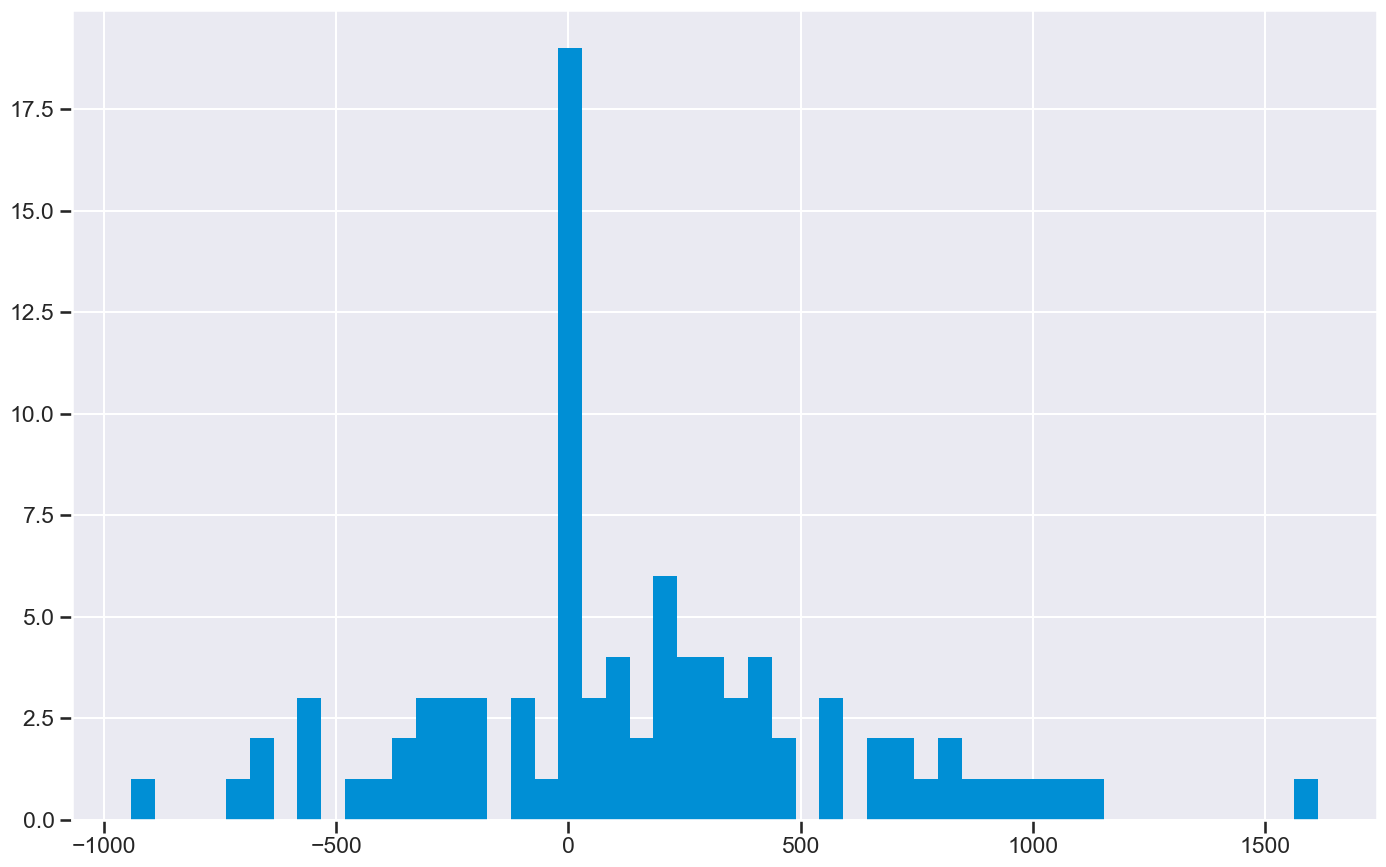

In [861]:
resid.hist(bins=50) # my model is overpredicting judging on the residuals 

<Axes: >

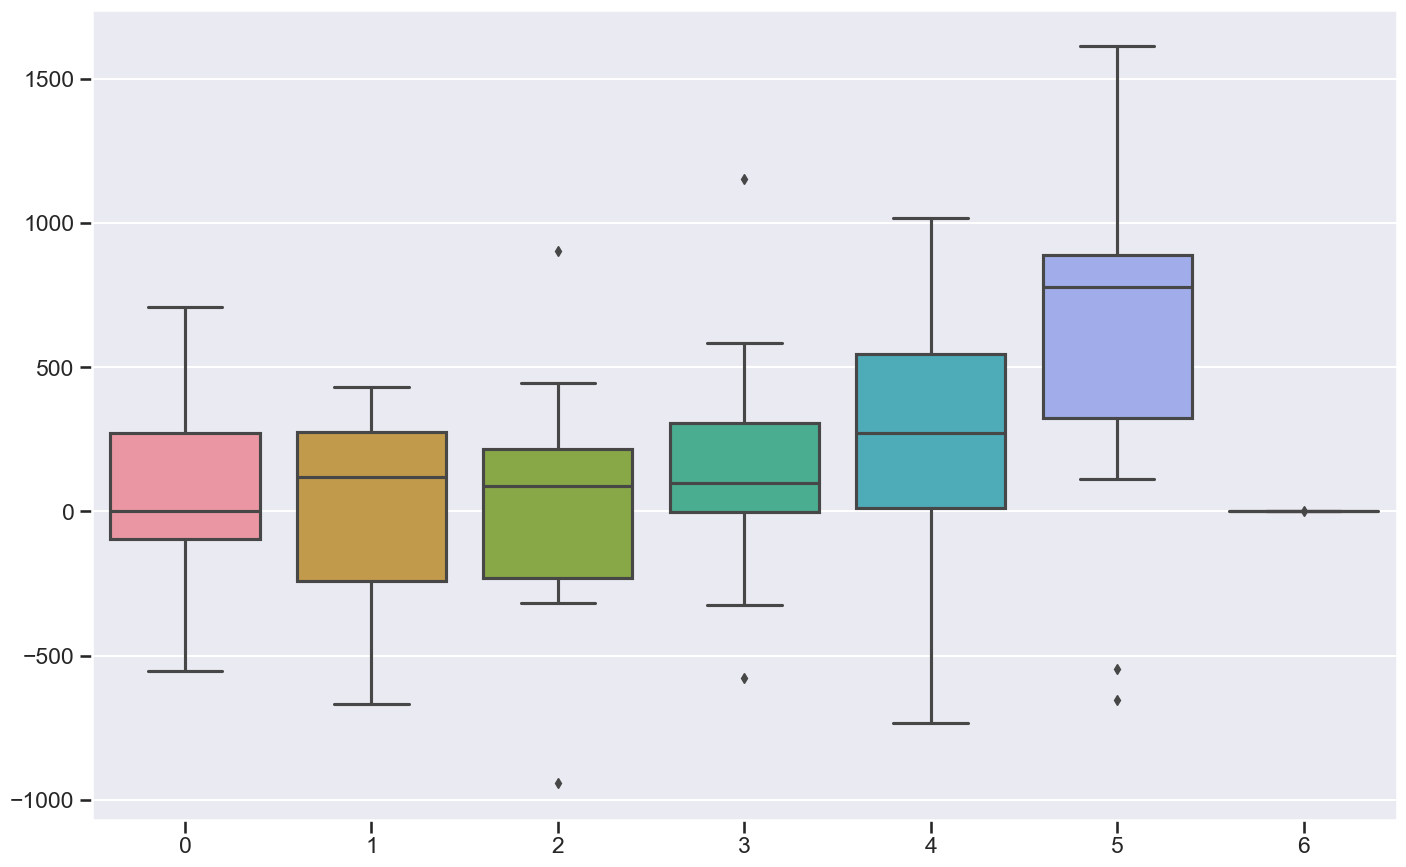

In [862]:
sns.boxplot(x=resid.index.dayofweek,y=resid) # hmmm I am over predicting on all days of the week... 

interesting, our model is over-predicting fridays and thursdays pretty heavily... 


Why? See below, it looks like a possible mistake of a "Promo" effect when the store is closed or sales are 0...

In [863]:
px.line(ts_1,
        x=ts_1.index,
        y='Sales',
        color='DayOfWeek',
        facet_row='Promo',
        title='Promotional Sales Patterns by DOW')

In [864]:
resid.name = 'residuals'
test.join(resid) # switch Open feature to a Closed feature...., definitely create or add all sundays to the "closed" dummy

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,residuals
Date,,,,,,,,,
2015-05-01,1,5,0,0,0,1,a,0,0.248444
2015-05-02,1,6,5850,653,1,0,0,0,-655.067797
2015-05-03,1,7,0,0,0,0,0,0,0.042595
2015-05-04,1,1,5591,589,1,1,0,0,-358.117716
2015-05-05,1,2,4564,514,1,1,0,0,432.766440
...,...,...,...,...,...,...,...,...,...
2015-07-27,1,1,6102,612,1,1,0,1,-553.965784
2015-07-28,1,2,5011,560,1,1,0,1,119.909096
2015-07-29,1,3,4782,523,1,1,0,1,217.645794


In [865]:
exog_1 = exog_trns.fit_transform(exog_1.assign(Date = exog_1.index.date,
                                      Closed = np.where(exog_1['Open'] == 0,1,0)).drop(columns='Open'))

exog_1 = exog_1.assign(Promo = np.where((exog_1['Promo'] == 1) & (exog_1['Closed'] == 0),1,0))

In [866]:
fin_exog = exog_1.loc[:valid_end]
fin_target = ts_1.loc[:valid_end,'Sales']

forecaster.fit(y=fin_target,
               exog = fin_exog)

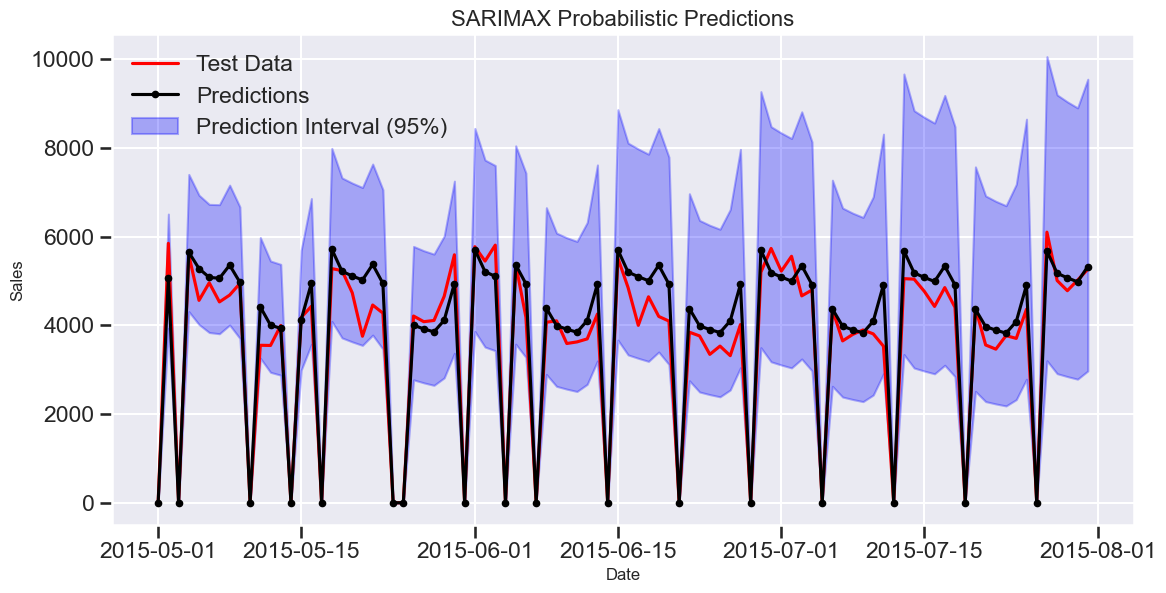

In [890]:
#finally a nice visual for the linkedin post :) 

preds = forecaster.predict_interval(steps=92,
                           exog = exog_1.iloc[-92:],
                           interval=[2.5,97.5])

# Plot the data
plt.figure(figsize=(12, 6.27))

#plt.plot(fin_target.loc['2014-10-01':].index,fin_target.loc['2014-10-01':],  color='grey',label='Train Data')
plt.plot(test.index, test['Sales'], color='red', label='Test Data')
plt.plot(preds.index, preds['pred'], color='black', label='Predictions',marker='.')
plt.fill_between(preds.index, preds['lower_bound'], preds['upper_bound'], color='blue', alpha=0.3, label='Prediction Interval (95%)')

# Add labels and title
plt.title('SARIMAX Probabilistic Predictions', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()

In [641]:
preds = forecaster.predict(steps=92,
                           exog = exog_1.iloc[-92:])

fig = go.Figure()

fig.add_trace(go.Scatter(x=valid['Sales'].index,
                         y=valid['Sales'],
                         mode='lines',
                         name='Train Set'),
             )

fig.add_trace(go.Scatter(x=test['Sales'].index,
                         y=test['Sales'],
                         mode='lines',
                         name='Test Set'),
             )

fig.add_trace(go.Scatter(x=preds.index,
                         y=preds,
                         mode='lines',
                     name='predictions'    ))

fig.update_layout(title='Training Data + Test and Predictions',
                  xaxis_title='Sales (Units)',
                  yaxis_title='Date')

In [667]:
from sklearn.metrics import mean_absolute_error 

mean_absolute_error(test['Sales'],preds) # we are off by 344 units on average. Not bad

344.7384347090988

lets see if we can somehow quantify that Friday effect...

lets use a grid search to see if we missed anything in the model construction process.

In [682]:
param_grid = {
    'order': [(1,1,4), (1,0,4), (1,1,5)],
    'seasonal_order': [(1, 0, 2, 7), (1, 1, 2, 7), (2, 1, 2, 7)],
    'trend': ['n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = train.loc[:valid_end,'Sales'],
                   exog = exog_1.loc[:valid_end],
                   param_grid            = param_grid,
                   steps                 = 120,
                   refit                 = False,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = 365,
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
results_grid.head(5)

Number of models compared: 18.


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



params grid:   0%|          | 0/18 [00:00<?, ?it/s]

,params,mean_absolute_error,order,seasonal_order,trend
11,"{'order': (1, 0, 4), 'seasonal_order': (2, 1, ...",597.232686,"(1, 0, 4)","(2, 1, 2, 7)",c
10,"{'order': (1, 0, 4), 'seasonal_order': (2, 1, ...",599.958448,"(1, 0, 4)","(2, 1, 2, 7)",n
13,"{'order': (1, 1, 5), 'seasonal_order': (1, 0, ...",603.592871,"(1, 1, 5)","(1, 0, 2, 7)",c
8,"{'order': (1, 0, 4), 'seasonal_order': (1, 1, ...",615.432657,"(1, 0, 4)","(1, 1, 2, 7)",n
9,"{'order': (1, 0, 4), 'seasonal_order': (1, 1, ...",617.710206,"(1, 0, 4)","(1, 1, 2, 7)",c


In [686]:
forecaster.params = results_grid.loc[11] #set params to best parameters found in grid search and see the new model fit 

In [688]:
forecaster.fit(y=fin_target,
               exog = fin_exog) # refit forecaster 

Evaluating the fit of the final model

In [691]:
preds = forecaster.predict(steps=92,
                           exog = exog_1.iloc[-92:])

fig = go.Figure()

fig.add_trace(go.Scatter(x=valid['Sales'].index,
                         y=valid['Sales'],
                         mode='lines',
                         name='Train Set'),
             )

fig.add_trace(go.Scatter(x=test['Sales'].index,
                         y=test['Sales'],
                         mode='lines',
                         name='Test Set'),
             )

fig.add_trace(go.Scatter(x=preds.index,
                         y=preds,
                         mode='lines',
                     name='predictions'    ))

fig.update_layout(title='SARIMAX Predictions',
                  xaxis_title='Sales (Units)',
                  yaxis_title='Date')

/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [690]:
from sklearn.metrics import mean_absolute_error 

mean_absolute_error(test['Sales'],preds)

310.42967123982925

lets add promos and closures to our future exog, assuming the exact same closures and promos are repeated 

In [713]:
promo_days = exog_1.query('Promo == 1').index.dayofyear#.astype(str)

In [714]:
ts_1.query('Open == 0').index.dayofweek.value_counts() # we will classify sundays as closed and use the US holidays calendar to signal other closures

Date
6    134
3     11
4      6
0      6
2      3
1      1
Name: count, dtype: int64

create German calendar as Rossmann's is headquartered in Germany (operating on that assumption for the sake of brevity ;))

In [720]:
import pandas as pd
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, HolidayCalendarFactory

class GermanHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('Neujahr', month=1, day=1),
        Holiday('Tag der Arbeit', month=5, day=1),
        Holiday('Tag der Deutschen Einheit', month=10, day=3),
        Holiday('1. Weihnachtstag', month=12, day=25),
        Holiday('2. Weihnachtstag', month=12, day=26)
    ]

# Create German holiday calendar
cal = GermanHolidays()

# Specify the range of dates for which you want to generate holidays
start_date = fut_exog.index.min()
end_date = fut_exog.index.max()

# Generate the holiday dates within the specified range
holidays = cal.holidays(start=start_date, end=end_date)

# Convert the holiday dates to a DataFrame with a 'date' column
holidays_df = pd.DataFrame(holidays, columns=['date'])

# Add a column for the holiday names
holidays_df['holiday_name'] = holidays_df['date'].dt.strftime('%B %-d, %Y')

print("Holiday Calendar:")
print(holidays_df)


Holiday Calendar:
        date       holiday_name
0 2015-10-03    October 3, 2015
1 2015-12-25  December 25, 2015
2 2015-12-26  December 26, 2015
3 2016-01-01    January 1, 2016
4 2016-05-01        May 1, 2016


In [732]:
fut_exog = fut_exog.assign(Promo = np.where((fut_exog.index.dayofyear.isin(promo_days) 
                                             & ~(fut_exog.index.isin(holidays)) #we don't want to model promos that are running during store closure as these result in no sales
                                             & ~(fut_exog.index.dayofweek == 6))
                                            ,1,0),
                #add closures on sundays and holidays 
                Closed = np.where((fut_exog.index.dayofweek == 6) | 
                                  (fut_exog.index.isin(holidays)),1,0))

fut_exog = exog_trns.transform(fut_exog)

fut_exog.head()

,Promo,Closed,Date_day_of_week_1,Date_day_of_week_2,Date_day_of_week_3,Date_day_of_week_4,Date_day_of_week_5,Date_day_of_week_6
2015-08-01,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-08-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-04,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-08-05,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [734]:
#fit model on all of the data and predict 

forecaster.fit(y=ts_1['Sales'],
               exog = exog_1)

preds = forecaster.predict(steps=len(fut_exog),
                   exog = fut_exog)

In [737]:
#plot predictions 
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid['Sales'].index,
                         y=valid['Sales'],
                         mode='lines',
                         name='Train Set'),
             )

fig.add_trace(go.Scatter(x=test['Sales'].index,
                         y=test['Sales'],
                         mode='lines',
                         name='Test Set'),
             )

fig.add_trace(go.Scatter(x=preds.loc[:'2015'].index,
                         y=preds,
                         mode='lines',
                     name='Future'))

fig.update_layout(title='SARIMAX Predictions',
                  xaxis_title='Sales (Units)',
                  yaxis_title='Date')

/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [891]:
forecaster.regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Sales   No. Observations:                  850
Model:             SARIMAX(1, 1, 4)x(1, 1, [1, 2], 7)   Log Likelihood                 562.777
Date:                                Sun, 02 Jun 2024   AIC                          -1091.554
Time:                                        17:19:34   BIC                          -1011.046
Sample:                                    01-01-2013   HQIC                         -1060.701
                                         - 04-30-2015                                         
Covariance Type:                                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Promo                  0.2659      0.012     22.878      0.000       0.243       0.289
Closed                -8.3937      0.025   -331.373      0.000      -8.443      -8.344
Date_day_of_week_1  2.115e-07   1.35e-07      1.566      0.117   -5.31e-08    4.76e-07
Date_day_of_week_2 -2.343e-07   1.48e-07     -1.582      0.114   -5.25e-07     5.6e-08
Date_day_of_week_3  1.164e-07    1.3e-07      0.896      0.370   -1.38e-07    3.71e-07
Date_day_of_week_4 -2.664e-08   1.44e-07     -0.185      0.853   -3.08e-07    2.55e-07
Date_day_of_week_5   2.33e-08   1.39e-07      0.167      0.867    -2.5e-07    2.96e-07
Date_day_of_week_6  9.965e-08   1.39e-07      0.719      0.472   -1.72e-07    3.71e-07
ar.L1                 -0.7734      0.070    -11.045      0.000      -0.911      -0.636
ma.L1                  0.1028      0.074      1.389      0.165      -0.042       0.248
ma.L2                 -0.5753      0.059     -9.814      0.000      -0.690      -0.460
ma.L3                 -0.0055      0.034     -0.159      0.874      -0.073       0.062
ma.L4                 -0.1337      0.033     -4.107      0.000      -0.197      -0.070
ar.S.L7               -0.9123      0.554     -1.648      0.099      -1.997       0.173
ma.S.L7               -0.0918      0.586     -0.157      0.875      -1.240       1.056
ma.S.L14              -0.9067      0.615     -1.474      0.140      -2.112       0.299
sigma2                 0.0148      0.003      4.850      0.000       0.009       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               571.18
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.48e+20. Standard errors may be unstable.
"""

in a future notebook, I will utilize VAR to forecast this as a multivariate problem given the strong relationship in sales and customers.